In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# try reading the CSV file with different encodings
encodings_to_try_review = ['utf-8', 'latin1', 'ISO-8859-1']

for encoding_review in encodings_to_try_review:
    try:
        df_original = pd.read_csv("movie_reviews.csv", encoding=encoding_review)
        break # if successful, break out of the loop
    except UnicodeDecodeError:
        continue

df_original.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [2]:
print("number of rows: ",len(df_original))

number of rows:  50000


In [3]:
# we'll work with a subset of data to save computational costs
df_review = df_original.loc[:20000,:].copy()

# remove all missing values (e.g. NaN values) from the table.
df_review.dropna(inplace = True)

# count_words() counts the number of words in a text string
def count_words(text):
    """
    input: a string, typically a movie review raw text
    output: the number of words
    """
    words = re.findall(r'\b\w+\b', text)
    return len(words)

# create a new column 'word count' that counts the number of words in a review
df_review['word_count'] = df_review['review'].apply(count_words)

# rename the 'review' column name to 'raw text' to avoid confusion later
df_review.rename(columns = {'review' : 'raw_text'}, inplace = True)

# exclude characters other than A-Z and a-z on the ASCII table
non_english_characters = ["<br />"] + [chr(i) for i in range(0, 32)] + [chr(i) for i in range(33, 65)] + [chr(i) for i in range(91, 97)] + [chr(i) for i in range(123, 256)]

# combine non-English characters into a single regular expression pattern. map() is used to apply re.escape to every character in non_english_characters
pattern = '|'.join(map(re.escape, non_english_characters))

# apply the replacement to the entire column in one go
df_review['raw_text'] = df_review['raw_text'].replace(pattern, '', regex=True)

df_review.head()

,raw_text,sentiment,word_count
0,One of the other reviewers has mentioned that ...,positive,320
1,A wonderful little production The filming tech...,positive,166
2,I thought this was a wonderful way to spend ti...,positive,172
3,Basically theres a family where a little boy J...,negative,141
4,Petter Matteis Love in the Time of Money is a ...,positive,236


In [4]:
import string

# function that removes all punctuation from a given text string
def remove_punct(text):
    punct_free = "".join([i for i in text if i not in string.punctuation])
    return punct_free

# creates another column of modified text, 'no punctuation text'
df_review['modified_text'] = df_review['raw_text'].apply(remove_punct)

df_review = df_review[['raw_text', 'modified_text', 'sentiment', 'word_count']]

df_review.head()

,raw_text,modified_text,sentiment,word_count
0,One of the other reviewers has mentioned that ...,One of the other reviewers has mentioned that ...,positive,320
1,A wonderful little production The filming tech...,A wonderful little production The filming tech...,positive,166
2,I thought this was a wonderful way to spend ti...,I thought this was a wonderful way to spend ti...,positive,172
3,Basically theres a family where a little boy J...,Basically theres a family where a little boy J...,negative,141
4,Petter Matteis Love in the Time of Money is a ...,Petter Matteis Love in the Time of Money is a ...,positive,236


In [5]:
# tokenize text into words
# FYI, \W means non-english-characters, e.g. an empty space, a tab, etc. '+' means 'at least one such character'
def tokenization(text):
    tokens = re.split('\W+',text)
    return tokens

# applying function to the column
df_review['modified_text']= df_review['modified_text'].apply(tokenization)

df_review.head()

,raw_text,modified_text,sentiment,word_count
0,One of the other reviewers has mentioned that ...,"[One, of, the, other, reviewers, has, mentione...",positive,320
1,A wonderful little production The filming tech...,"[A, wonderful, little, production, The, filmin...",positive,166
2,I thought this was a wonderful way to spend ti...,"[I, thought, this, was, a, wonderful, way, to,...",positive,172
3,Basically theres a family where a little boy J...,"[Basically, theres, a, family, where, a, littl...",negative,141
4,Petter Matteis Love in the Time of Money is a ...,"[Petter, Matteis, Love, in, the, Time, of, Mon...",positive,236


In [6]:
# we now exclude stop words. Stop words are commonly used words like "a", "an", "and", etc. that are insignificant for our analysis

import nltk

# download the 'stopwords' resource if you don't haven't already
# nltk.download('stopwords')

# stop words present in the library
stopwords = nltk.corpus.stopwords.words('english')

# remove_stopwords() removes stopwords from tokenized text
def remove_stopwords(text):
    output= [i for i in text if i not in stopwords]
    return output

df_review['modified_text']= df_review['modified_text'].apply(remove_stopwords)

df_review.head()

,raw_text,modified_text,sentiment,word_count
0,One of the other reviewers has mentioned that ...,"[One, reviewers, mentioned, watching, Oz, epis...",positive,320
1,A wonderful little production The filming tech...,"[A, wonderful, little, production, The, filmin...",positive,166
2,I thought this was a wonderful way to spend ti...,"[I, thought, wonderful, way, spend, time, hot,...",positive,172
3,Basically theres a family where a little boy J...,"[Basically, theres, family, little, boy, Jake,...",negative,141
4,Petter Matteis Love in the Time of Money is a ...,"[Petter, Matteis, Love, Time, Money, visually,...",positive,236


In [7]:
# now we lemmatize words
# think of lemmatization as a generalization of words to their base form. For example, we change "goes" and "going" to "go" and "did" to "do".

# download the 'wordnet' and 'omw-1.4' resources if you haven't already
# nltk.download('wordnet') # wordnet is a large lexical database in NLTK that helps with word relationships (synonyms, hypernyms, etc.) and is used for lemmatization
# nltk.download('omw-1.4')

from nltk.stem import WordNetLemmatizer

# define the object for Lemmatization
wordnet_lemmatizer = WordNetLemmatizer()

# define the function for lemmatization
def lemmatizer(wordlist):
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in wordlist]
    lemm_text = [wordnet_lemmatizer.lemmatize(word, pos='v') for word in lemm_text] # pos='v' lemmatizes verbs
    lemm_text = [wordnet_lemmatizer.lemmatize(word, pos='n') for word in lemm_text] # pos='n' lemmatizes nouns
    lemm_text = [wordnet_lemmatizer.lemmatize(word, pos='a') for word in lemm_text] # pos='a' lemmatizes adjectives
    lemm_text = [wordnet_lemmatizer.lemmatize(word, pos='r') for word in lemm_text] # pos='r' lemmatizes adverbs
    return lemm_text

# lemmatize each no-stopword-text reviews
df_review['modified_text']=df_review['modified_text'].apply(lemmatizer)

df_review.head()

,raw_text,modified_text,sentiment,word_count
0,One of the other reviewers has mentioned that ...,"[One, reviewer, mention, watch, Oz, episode, y...",positive,320
1,A wonderful little production The filming tech...,"[A, wonderful, little, production, The, film, ...",positive,166
2,I thought this was a wonderful way to spend ti...,"[I, think, wonderful, way, spend, time, hot, s...",positive,172
3,Basically theres a family where a little boy J...,"[Basically, there, family, little, boy, Jake, ...",negative,141
4,Petter Matteis Love in the Time of Money is a ...,"[Petter, Matteis, Love, Time, Money, visually,...",positive,236


In [8]:
# use scikit-learn's CountVectorizer to identify every unique word in the dataset and how many times each word appears in each review

from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(max_df = 0.2, min_df = 30, stop_words = 'english') # max_df=0.2: ignore words that appear in > 20% of the reviews; min_df=30: ignroe words that apear in < 30 reviews

counts = vec.fit_transform(df_review['raw_text'])
count_df = pd.DataFrame(counts.toarray(), columns = vec.get_feature_names_out()) # vec.get_feature_names_out() extracts the words to use as column names
df_review = pd.concat((df_review, count_df), axis = 1) # concatenate count_df to df_review

# keep only the columns that start with an English alphabet letter
filtered_cols = [col for col in df_review.columns if col[0].isalpha()]

# Select only the filtered columns from the DataFrame
df_review = df_review[filtered_cols]
df_review.head()

,raw_text,modified_text,sentiment,sentiment,word_count,aaron,abandon,abandoned,abc,abilities,...,youre,youth,youthful,youtube,youve,zany,zero,zombie,zombies,zone
0,One of the other reviewers has mentioned that ...,"[One, reviewer, mention, watch, Oz, episode, y...",positive,0,320,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A wonderful little production The filming tech...,"[A, wonderful, little, production, The, film, ...",positive,0,166,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,I thought this was a wonderful way to spend ti...,"[I, think, wonderful, way, spend, time, hot, s...",positive,0,172,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Basically theres a family where a little boy J...,"[Basically, there, family, little, boy, Jake, ...",negative,0,141,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,Petter Matteis Love in the Time of Money is a ...,"[Petter, Matteis, Love, Time, Money, visually,...",positive,0,236,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# remove duplicate 'sentiment' columns and restore original 'sentiment' column just in case it has been modified since we initially loaded in the data

sentiment_indices = [i for i, col in enumerate(df_review.columns) if col == 'sentiment']
df_review = df_review.drop(df_review.columns[sentiment_indices[1:]], axis=1) # drop every 'sentiment' column except the first one

encodings_to_try_review = ['utf-8', 'latin1', 'ISO-8859-1']

for encoding_review in encodings_to_try_review:
    try:
        df_review_original = pd.read_csv("movie_reviews.csv", encoding=encoding_review)
        break # if successful, break out of the loop
    except UnicodeDecodeError:
        continue

df_review['sentiment'] = df_review_original[['sentiment']] # double brackets return a DataFrame, while single brackets return a Series

display(df_review.head())

,raw_text,modified_text,word_count,aaron,abandon,abandoned,abc,abilities,ability,able,...,youth,youthful,youtube,youve,zany,zero,zombie,zombies,zone,sentiment
0,One of the other reviewers has mentioned that ...,"[One, reviewer, mention, watch, Oz, episode, y...",320,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,positive
1,A wonderful little production The filming tech...,"[A, wonderful, little, production, The, film, ...",166,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,positive
2,I thought this was a wonderful way to spend ti...,"[I, think, wonderful, way, spend, time, hot, s...",172,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,positive
3,Basically theres a family where a little boy J...,"[Basically, there, family, little, boy, Jake, ...",141,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,negative
4,Petter Matteis Love in the Time of Money is a ...,"[Petter, Matteis, Love, Time, Money, visually,...",236,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,positive


In [10]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_review, test_size=0.4, random_state=42) # 60% of the data used for training, 40% used for testing

# define the features and target variable
features_to_drop = ['raw_text', 'modified_text', 'sentiment', 'word_count']

X_train, y_train = train.drop(features_to_drop, axis=1), train['sentiment']
X_test, y_test = test.drop(features_to_drop, axis=1), test['sentiment']

In [11]:
# perform logistic regression and compute cross validation score

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

LR = LogisticRegression(max_iter = 500) # max_iter sets the maximumm number of iterations the algorithm can take to converge, in this case, 500
LR.fit(X_train, y_train)

print(LR.score(X_train, y_train), cross_val_score(LR, X_train, y_train, cv = 5).mean()) # 5-fold cross validation: the dataset is split into 5 subsets (folds) and the model is trained on 4 subsets and tested on the 5th. Repeated 5 times 

0.9945 0.843


In [12]:
# calculate the best value of the hyperparameter C that gives us best accuracy
# the C hyperparameter is the inverse of regularization strength. A smaller C (stronger regularization) forces the model to create simpler models by shrinking coefficients. A larger C (weaker regularization) allows the model to fit the training data more closely

best_C = 0.005 # initialize best_C to the starting value in our search
best_cv_score = 0
for C in np.linspace(0.005, 0.05, 10):
    LR = LogisticRegression(C = C, max_iter = 1000)
    cv_score = cross_val_score(LR, X_train, y_train, cv = 5).mean()
    if cv_score > best_cv_score:
        best_cv_score = cv_score
        best_C = C

In [13]:
best_C

0.045000000000000005

In [14]:
# perform logistic regression again, this time with best_C as the hyperparameter C

LR = LogisticRegression(C = best_C, max_iter = 1000)
LR.fit(X_train, y_train)
LR.score(X_test, y_test)

0.8665166854143233

In [15]:
# return an unordered list of each unique word with its coefficient (weight)

word_weight_df = pd.DataFrame({"word" : X_train.columns, "weight" : LR.coef_[0], })
word_weight_df

,word,weight
0,aaron,0.056889
1,abandon,0.072087
2,abandoned,-0.116193
3,abc,0.157269
4,abilities,-0.047235
...,...,...
7189,zany,0.009487
7190,zero,-0.125794
7191,zombie,0.011963
7192,zombies,-0.250915


In [16]:
# ten lowest coefficients

word_weight_df.sort_values('weight', ascending = True).head(10)

,word,weight
7132,worst,-1.134697
6971,waste,-1.081030
454,awful,-0.915407
687,boring,-0.766548
7130,worse,-0.714101
3082,horrible,-0.669660
440,avoid,-0.657168
6405,terrible,-0.610639
1806,disappointing,-0.603981
4764,poorly,-0.581731


In [17]:
# ten highest coefficients

word_weight_df.sort_values('weight', ascending = False).head(10)

,word,weight
2214,excellent,0.781086
3823,loved,0.725388
2378,favorite,0.613965
751,brilliant,0.608544
7105,wonderful,0.572856
2351,fantastic,0.552104
218,amazing,0.534761
4623,perfect,0.496487
577,best,0.490605
5110,realistic,0.487540


In [18]:
# calculate total scores for each review (sum of the scores of every word in the review)


df_data = df_review[['raw_text','modified_text','sentiment','word_count']].copy()

word_weight_dict = dict(zip(word_weight_df['word'], word_weight_df['weight'])) # define dictionary to hold words and corresponding weights

# total_score_vectorized() returns the sum of the weights of each word in the inputted text
def total_score_vectorized(text_list):
    return sum(word_weight_dict.get(word, 0) for word in text_list)

df_data['total_score'] = df_data['modified_text'].apply(total_score_vectorized)
df_data.head(20)

,raw_text,modified_text,sentiment,word_count,total_score
0,One of the other reviewers has mentioned that ...,"[One, reviewer, mention, watch, Oz, episode, y...",positive,320,-0.668861
1,A wonderful little production The filming tech...,"[A, wonderful, little, production, The, film, ...",positive,166,0.863344
2,I thought this was a wonderful way to spend ti...,"[I, think, wonderful, way, spend, time, hot, s...",positive,172,1.538357
3,Basically theres a family where a little boy J...,"[Basically, there, family, little, boy, Jake, ...",negative,141,-0.582157
4,Petter Matteis Love in the Time of Money is a ...,"[Petter, Matteis, Love, Time, Money, visually,...",positive,236,1.402262
5,Probably my alltime favorite movie a story of ...,"[Probably, alltime, favorite, movie, story, se...",positive,125,1.863275
6,I sure would like to see a resurrection of a u...,"[I, sure, would, like, see, resurrection, date...",positive,161,-0.316757
7,This show was an amazing fresh innovative ide...,"[This, show, amaze, fresh, innovative, idea, f...",negative,181,-3.652444
8,Encouraged by the positive comments about this...,"[Encouraged, positive, comment, film, I, look,...",negative,130,-1.441834
9,If you like original gut wrenching laughter yo...,"[If, like, original, gut, wrench, laughter, li...",positive,34,0.106587


In [19]:
df_data['average_word_score'] = df_data['total_score']/df_data['word_count']

correlation = df_data['average_word_score'].corr(df_data['sentiment'].map({'positive': 1, 'negative': 0})) # corr() requires numeric values, so we map 'sentiment' to 1 and 0
print(f"Correlation between average word score and sentiment: {correlation}")

Correlation between average word score and sentiment: 0.6673423398914857


In [20]:
correlation = df_data['total_score'].corr(df_data['sentiment'].map({'positive': 1, 'negative': 0}))
print(f"Correlation between total score and sentiment: {correlation}")

Correlation between total score and sentiment: 0.6523385108521703


In [21]:
# bin_list() generates 10 equal-size intervals based on the minimum and maximum total scores
def bin_list(df):
    max_word_score = df['total_score'].max()
    min_word_score = df['total_score'].min()
    return np.linspace(min_word_score,max_word_score,11)

# define the bins and labels
bins = bin_list(df_data)
labels = np.arange(1,11)

df_data['star_rating (out of 10)'] = pd.cut(df_data['total_score'], bins = bins, labels = labels, right = True) # sort reviews into bins with pd.cut(). right=True makes the bins right-inclusive

pd.set_option('display.max_colwidth', 600) # increase display width of columns so we can see more words
print("The below are some of the 2-star reviews: ")
display(df_data[df_data['star_rating (out of 10)'] == 2][['raw_text']].head(10))
print("The below are some of the 4-star reviews: ")
display(df_data[df_data['star_rating (out of 10)'] == 4][['raw_text']].head(10))
print("The below are some of the 6-star reviews: ")
display(df_data[df_data['star_rating (out of 10)'] == 6][['raw_text']].head(10))
print("The below are some of the 8-star reviews: ")
display(df_data[df_data['star_rating (out of 10)'] == 8][['raw_text']].head(10))
print("The below are some of the 10-star reviews: ")
display(df_data[df_data['star_rating (out of 10)'] == 10][['raw_text']].head(10))
pd.set_option('display.max_colwidth', 200) # reset display width for future outputs

The below are some of the 2-star reviews: 


,raw_text
1057,The review on the main page admits that the movie is horrible but that you should forgive it because it is nicely violent No you shouldnt There are spoilers at the end of this review but how I can spoil this rotten movie I have no idea Even if you are a die hard AlienPred fan like I am wait for the DVD It isnt worth a rental either but youll be much less inclined to truly hate this film if you pay that than bucks or better per person plus concession purchases at a theaterIn the theater I watched AVPr there were exactly two laughs both by a girl sitting next to me Other than that there wa...
1735,Komodo vs Cobra starts as One Planet environmentalist Jerry Ryan Ryan McTavish his girlfriend Carrie Renee Talbert hire Captain Michael Stoddard executive producer Michael Par to take them to an island in the South Pacific at first Stoddard is reluctant since the island is a top secret military research base but soon changes his mind when a load of cash is offered Along with TV news reporter Sandra Crescent Jeri Manthey they set sail for the island once ashore find out that the military have been funding illegal DNA genetic experiments which have resulted in huge Komodo Dragons King Cob...
3595,I knew it was going to be awful but not this awful as its one of the most boring movies i have ever seen not a damn thing happens All the characters are dull and the story is stupid and incredibly boringplus The ending is especially lame The only reason i rented this piece of crap because i am a big fan of Michael Dudikoff however he is wasted here and looks extremely bored and shows no emotion what so ever plus i cheered out loud when the movie was over Its like the movie had no plot and it was all about nothing and IceT is god awfuleven though he is OK in some stuff plus Dudikoff and Yve...
4894,Scarecrow is set in the small American town of Emerald Grove where high school student Lester Dwervick Tim Young is considered the local nerdy geek by teachers fellow students alike The poor kid suffers daily humiliation bullying teasing general esteem destroying abuse at the hands of his peers Unfortunately he doesnt find much support at home since his mom is a slut after Lester annoys one of her blokes he chases him into a corn field strangles the poor kid However something magical happens no the film doesnt suddenly become good Lesters spirit gets transfered into the corn fields sca...
6499,The Salena Incident is set in Arizona where six death row inmates are being transfered from the state prison for reasons never explained while driving along the heavily armed prison bus gets a flat the driver is forced to pull off the road Then two blonde birds turn up after seducing the incompetent prison guards manage to get the better of them the six prisoners are released but in a shootout their getaway car is damaged leaving them all stranded in the middle of the Arizona desert They decide to head to the nearest town Salena several miles away take the cops with them as hostage Once...
7602,The Bone Collector is set in New York City starts as one of the worlds foremost criminologists crime scene experts Lincoln Rhyme Denzel Washington is involved in an accident which leaves him a bedridden quadriplegic Jump forward four years Alan Gary Swanson his wife Lindsay Rubin Olivia Birkelund are kidnapped soon after New York cop Amelia Donaghy Angelina Jolie is called to a crime scene finds the buried mutilated body of Alan Amelia notices some unusual crime scene evidence makes a note of it which impresses Rhyme when he is asked to work on the case he quickly realises the evide...
9088,Critters starts I quote Somewhere in Kansas a replay of the last few minutes of Critters as the recurring character of Charlie McFadden Don Keith Opper is about to shoot the last two remaining Critter eggs in the universe which we are informed would mean the extinction of the entire Critter race which is against some sort of intergalactic zoological law or something like 

The below are some of the 4-star reviews: 


,raw_text
83,Fate leads Walter Sparrow to come in possession of a mysterious novel that has eerie similarities and connections to his life all based around the number As the story unfolds in real life and fiction Sparrow must figure out his connection to the book and how the story will eventually endThe Number offers an intriguing premise that is undone by a weak execution The film just failed on many different levels which is pretty disappointing because it held so much potential The screenplay was probably the worst part about it It was filled with silly sequences and laughable dialog that just kil...
163,This is one of a rarity of movies where instead of a bowl of popcorn one should watch it with a bottle of vodka To be completely honest we are a group of people who actually know the man Mo Ogrodnik and decided to drink ourselves stupid to this filmThe cinematic aspect of Wolfgang Somethings photography seems to have left out both closeups and breasts Mo and Wolfgangs collaborative effort revealed the passion of the two actresses plastic peens holding passion Theres also beetle banging As Violet would have put it This plastic peen goes up your butt The rat porn and subsequent rat smashing ...
295,Despite a totally misleading advertising campaign this flick turns out to be an irritatingly clichd subpar haunted house flick with a totally implausible ending Clue for all considering seeing this turkey Sam Raimi didnt direct it Although commercials for the movie play up his involvement in truth he is one of four producers Its too bad that someone as talented as Raimi has allowed his name to be used in conjunction with such a poor movie I dont think he would ever have directed something like this that task was left to the Pang BrothersThe screenplay for this film seems to have been cobb...
365,Years ago when DARLING LILI played on TV it was always the pan and scan version which I hated and decided to wait and see the film in its proper widescreen format So when I saw an inexpensive DVD of this Julie AndrewsBlake Edwards opus I decided to purchase and watch it once and for allBoy what a terrible film Its so bad and on so many levels that I really do not know where to start in describing where and when it goes so horribly wrong Looking at it now its obvious to any fans of movies that Blake Edwards created this star vehicle for his wife simply because so many other directors had st...
514,First let me just comment on what I liked about the movie The special effects were fantastic and very rarely did I feel like I was watching a video game There that is the last nice thing I have to say about this film In fact I would just like everyone reading this to take note that I cant even put into words how hard it was for me to write this review without swearing I have innumerable complaints about the film but four major complaints jump to mind My first major complaint has to do with the incredible cheesiness of the plot twist if you can call it that since most people probably saw it...
559,So I rented this from Netflix because somebody gave me Roger Eberts book I hated hated hated this movie and he gave this one a rare zerostar rating in the book and said at the end of his original review Mad Dog Time should be cut up to provide free ukulele picks for the poor So I figured from Ebert saying that I would see if it was really as bad as he said it was I know most society says not to listen to critics and to judge for yourself but I could not express how much I hated this piece of junk like Ebert did and never since Eberts review of Rob Reiners North where he said he hated that ...
617,All the way though i was thinking to myself Oh god why At the very beginning i thought Right it might be average but the acting and plot on most parts was atrociousEvery part in it was so predictable even though the first movie seemed to bare a large resemblance to the ring it was a half decent movie but this just seemed to take all the good things about the first

The below are some of the 6-star reviews: 


,raw_text
0,One of the other reviewers has mentioned that after watching just Oz episode youll be hooked They are right as this is exactly what happened with meThe first thing that struck me about Oz was its brutality and unflinching scenes of violence which set in right from the word GO Trust me this is not a show for the faint hearted or timid This show pulls no punches with regards to drugs sex or violence Its is hardcore in the classic use of the wordIt is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary It focuses mainly on Emerald City an experimental sec...
3,Basically theres a family where a little boy Jake thinks theres a zombie in his closet his parents are fighting all the timeThis movie is slower than a soap opera and suddenly Jake decides to become Rambo and kill the zombieOK first of all when youre going to make a film you must Decide if its a thriller or a drama As a drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film I expected to see a BOOGEYMAN similar movie and instead i watched a drama with some meaningless thriller spots out of just ...
6,I sure would like to see a resurrection of a up dated Seahunt series with the tech they have today it would bring back the kid excitement in meI grew up on black and white TV and Seahunt with Gunsmoke were my heros every weekYou have my vote for a comeback of a new sea huntWe need a change of pace in TV and this would work for a world of under water adventureOh by the way thank you for an outlet like this to view many viewpoints about TV and the many moviesSo any ole way I believe Ive got what I wanna sayWould be nice to read some more plus points about sea huntIf my rhymes would be lines...
7,This show was an amazing fresh innovative idea in the s when it first aired The first or years were brilliant but things dropped off after that By the show was not really funny anymore and its continued its decline further to the complete waste of time it is todayIts truly disgraceful how far this show has fallen The writing is painfully bad the performances are almost as bad if not for the mildly entertaining respite of the guesthosts this show probably wouldnt still be on the air I find it so hard to believe that the same creator that handselected the original cast also chose the ba...
8,Encouraged by the positive comments about this film on here I was looking forward to watching this film Bad mistake Ive seen films and this is truly one of the worst of them its awful in almost every way editing pacing storyline acting soundtrack the films only song a lame country tune is played no less than four times The film looks cheap and nasty and is boring in the extreme Rarely have I been so happy to see the end credits of a film The only thing that prevents me giving this a score is Harvey Keitel while this is far from his best performance he at least seems to be making a bit...
10,Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlinesAt first it was very odd and pretty funny but as the movie progressed I didnt find the jokes or oddness funny anymoreIts a low budget film thats never a problem in itself there were some pretty interesting characters but eventually I just lost interestI imagine this film would appeal to a stoner who is currently partakingFor something similar but better try Brother from another planet
11,I saw this movie when I was about when it came out I recall the scariest scene was the big bird eating men dangling helplessly from parachutes right out of the air The horror The horrorAs a young kid going to these cheesy B films on Saturday afternoons I still was tired of the formula for these monster type movies that usually included the hero a beautiful woman who might be the daughter of a professor and a happy resolution when the monster died in the end I didnt

The below are some of the 8-star reviews: 


,raw_text
29,War movie is a Hollywood genre that has been done and redone so many times that clichd dialogue rehashed plot and overthetop action sequences seem unavoidable for any conflict dealing with largescale combat Once in a while however a war movie comes along that goes against the grain and brings a truly original and compelling story to life on the silver screen The Civil Warera Cold Mountain starring Jude Law Nicole Kidman and Rene Zellweger is such a filmThen again calling Cold Mountain a war movie is not entirely accurate True enough the film opens with a quite literally quickanddirty battl...
33,One of the most significant quotes from the entire film is pronounced halfway through by the protagonist the mafia middleman Titta Di Girolamo a physically nondescript middleaged man originally from Salerno in Southern Italy When were introduced to him at the start of the film hes been living a nonlife in an elegant but sterile hotel in the Italianspeaking Canton of Switzerland for the last ten years conducting a business we are only gradually introduced to While this pivotal yet apparently unremarkable scene takes place employees of the the Swiss bank who normally count Di Girolamos cash ...
41,This movie is based on the book A Many Splendored Thing by Han Suyin and tackles issues of race relations between Asians and Whites a topic that comes from Hans personal experiences as an Eurasian growing up in China That background and the beautiful Hong Kong settings gives this love story a unique and rather daring atmosphere for its timeOther than that the story is a stereotypical romance with a memorable song that is perhaps more remembered than the movie itself The beautiful Jennifer Jones looks the part and gives a wonderful Oscar nominated performance as a doctor of mixed breed duri...
130,Two hours ago I was watching this brilliant movie which overwhelmed me with its imprisoning photography It is quite understandable how it won the prize of Best Camera in Cannes Close ups predominated it Close ups of walls humans and of many other things The warm colored lighting which is also usually by the director gave the movie a warm atmosphere Only two persons are principally to be seen in most of it An interesting music and especially three songs or themes accompanied the movie nearly all the time Each one of these themes represented a certain atmosphere during the whole movie Silen...
157,Ive always enjoyed films that depict life as it is Life sometimes has boring patches no real plot and not necessarily a happy ending A River Runs Through It is the perfect name for this film and Norman Macleans novel Life ebbs and flows like a river and it has its rough spots but it is a wonderful tripRobert Redford brings a lot to the film His narration has a friendly feel that fits the picture perfectly As a director he is restrained and calm and captures some incredibly beautiful scenes As for the acting Craig Sheffer and Brad Pitt work surprising well as brothers I dont know quite how ...
172,The Elegant Documentary Dont watch this movie if youre an egotistical knowall student of physics This much less than one percent miniscule fraction of the population may find that this show just tells them what they have already learned and already knowDo watch this movie If youre one of the massive majority of people that fall into the greater than of the population that does not study or already have a sound knowledge of the theories of physics including Relativity Quantum String and MtheoryWhat a brilliantly architected documentary Starting with some helpful historical background you...
191,The Golden Door is the story of a Sicilian familys journey from the Old World Italy to the New World America Salvatore a middleaged man who hopes for a more fruitful life persuades his family to leave their homeland behind in Sicily take the arduous journey across the raging seas and inhabit a land whose rivers supposedly flow with milk In short they believe that by 

The below are some of the 10-star reviews: 


,raw_text
1041,Mukhsin is a beautiful movie about a first love story Everyone probably has one and this is writerdirector Yasmin Ahmads story of hers with a boy called Mukhsin We know that her movies have been semiautobiographical of sorts having scenes drawn upon her personal experiences and it is indeed this sharing and translating of these emotions to the big screen that has her films always exude a warm sincerity and honesty Mukhsin is no different and probably the most polished ad confident work to date though I must add as a personal bias that Sepet still has a special place in my heartOur favourit...
5928,Only once in a while do we get an Rrated comedy that gets everyones time and attention Its an even rarer case when the critics will like it I just came back from The YearOld Virgin and I can honestly say it was one of the biggest laughs of my life I went to a showing and every row was filled Not only that everyone laughed their ass off the whole time through Its two hours of nonstop laughing I dare you to see this film and to not laughThe plot is simple A man is forty years old and he is a virgin Yet behind this simple five second joke we are given a deep complex story that is not only o...
9549,Oftentimes films of this nature come across as a mixed bag of great work along with slight drivel to fill the runtime Whether it be the big name support or the project itself Paris je taime never falls into this realm I believe I can truly say that the movie as a whole is better than its parts Between the wonderful transitions and the fantastic ending sequence merging characters together in one last view of love in Paris I think the film would have suffered if any cog was removed True there are definitely a few standouts that overshadow the rest but in the end I have a lasting image even i...
13313,When people nowadays hear of a s drama they usually appear to create a distance of irony claiming that its another tearjerker with great stars in the lead of tragic melancholic roles This opinion however does not resemble Neorealist movies in particular this one directed by Count Luchino Visconti OSSESSIONE as his debut once censored and once cherished as nearly a realistic masterpiece is still loved by some people and strongly criticized by others The contradictory opinions about the film that have appeared in these years seem to have been caused by the content of the movie itself except...
16498,The quintessential Georgian film of Georgi Danelia Ne goryuy aka Dont Grieve is loosely based on the novel by French writer Claude Tillier Mon oncle Benjamin The novel takes place in the country side of the th Century France The Great French Revolution is still ahead but some of its stormy signs are present in society Benjamin the local doctor is a soul of a local society the educated friendly democratic person who often treats the poor for free It makes him very popular with the locals but most certainly does not help with his bank account He is in love with a beautiful Manette who is a...


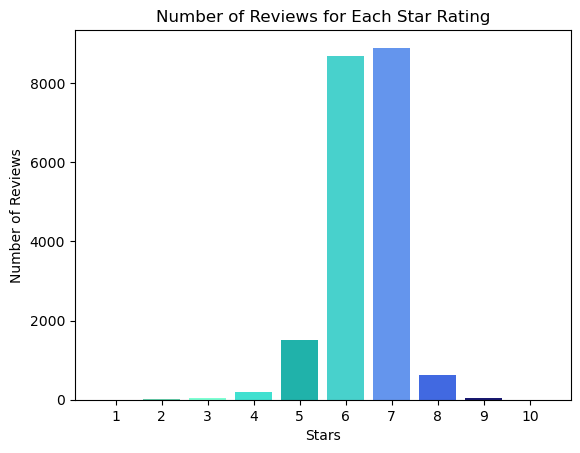

In [22]:
# plot distribution of star ratings

def review_counter(df, stars):
    return df['star_rating (out of 10)'][df['star_rating (out of 10)'] == stars].count()

fig, ax = plt.subplots() # use plt.subplots() to allow for customizable plots
stars = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
counts = [review_counter(df_data, 1),review_counter(df_data, 2),review_counter(df_data, 3),
          review_counter(df_data, 4),review_counter(df_data, 5),review_counter(df_data, 6),
          review_counter(df_data, 7),review_counter(df_data, 8),review_counter(df_data, 9),
          review_counter(df_data, 10)]
bar_colors = ['mediumspringgreen', 'mediumaquamarine', 'aquamarine', 'turquoise', 'lightseagreen'
              , 'mediumturquoise', 'cornflowerblue', 'royalblue', 'midnightblue', 'darkslategray']

ax.bar(stars, counts, color=bar_colors)
ax.set_ylabel('Number of Reviews')
ax.set_xlabel('Stars')
ax.set_title('Number of Reviews for Each Star Rating')

plt.show()

In [23]:
print(type(word_weight_df[word_weight_df['word'] == 'excellent']['weight'].values))
print(word_weight_df[word_weight_df['word'] == 'excellent']['weight'].values[0])

<class 'numpy.ndarray'>
0.7810864348906393


In [24]:
# word_weight() returns the weight of a word as listed in word_weight_df. If the word isn't in word_weight_df, word_weight() returns 0
def word_weight(word):
    if word in word_weight_df['word'].values:
        row_appearing = word_weight_df[word_weight_df['word'] == word]
        return row_appearing['weight'].values[0] # we have to take the 0 index because row_appearing['weight'].values itself is a numpy array
    else:
        return 0

# total_score() sums up the weights of every word in a given review
def total_score(text_list):
    score = 0
    for word in text_list:
        score += word_weight(word)
    return score

# all_preprocessed_text() preprocesses raw review text. Steps include removing punctuation, tokenization, removing stopwords, and lemmatization
def all_preprocessed_text(string):
    punct_free = remove_punct(string)
    tokens = tokenization(punct_free)
    no_stopwords = remove_stopwords(tokens)
    lemmatized = lemmatizer(no_stopwords)
    return lemmatized

# review_score() returns the rating of a review
def review_score(sample):
    score_sample = total_score(all_preprocessed_text(sample))
    for i in range(10):
        if (bins[i] <= score_sample) and (score_sample <= bins[i+1]):
            return i+1

In [25]:
# rate an empty string

review_sample_demo = ""

print("The sample's review score is: ",review_score(review_sample_demo))

The sample's review score is:  7


### The following passage is the *Oppenheimer* review used as review_sample1

Oppenheimer is an exceptional film that deserves the highest praise for its thought-provoking narrative, exquisite craftsmanship, and compelling performances. From the very first frame, the movie draws the audience into the fascinating world of J. Robert Oppenheimer, the brilliant physicist whose contributions during World War II profoundly altered the course of history. The films director, screenwriters, and production team have demonstrated remarkable talent and dedication in bringing Oppenheimers complex story to the screen. The meticulous attention to historical accuracy and period details adds a layer of authenticity, transporting viewers back in time to witness the scientific breakthroughs and tumultuous events that unfolded during the Manhattan Project. Cillian Murphys portrayal of J. Robert Oppenheimer is nothing short of remarkable. His nuanced and captivating performance captures the inner conflicts and moral dilemmas faced by the renowned physicist as he grapples with the implications of his work. The supporting cast, including outstanding performances by the ensemble, further enriches the films narrative and emotional depth. Oppenheimer stands out not only as a biopic but also as a meditation on the complexities of scientific progress and its impact on humanity. The film delves into the ethical dilemmas faced by scientists during wartime, exploring the weight of their choices and the sacrifices they make for the greater good.　Furthermore, the films cinematography and art direction are stunning, creating a visual feast for the eyes. The sweeping landscapes, haunting laboratories, and evocative period settings transport viewers back to the 1940s, immersing them fully in the eras atmosphere. One of the films greatest strengths lies in its ability to strike an emotional chord with the audience. It deftly navigates the intricacies of Oppenheimers personal life, revealing the human side of this legendary figure. This emotional connection fosters a deep sense of empathy and understanding, making Oppenheimer more than just a historical account—it becomes a profound reflection on the human experience. The films musical score, composed by a talented maestro, complements the narrative beautifully, adding another layer of emotional resonance to the story. The music enhances key moments and intensifies the emotions felt throughout the film, creating an immersive and unforgettable cinematic journey. In conclusion, Oppenheimer is a cinematic masterpiece that deserves accolades for its exceptional storytelling, remarkable performances, and its ability to delve into the complexities of history and humanity. It celebrates the brilliance of J. Robert Oppenheimer while also encouraging us to contemplate the broader implications of scientific progress and the human spirit. A true gem among cinematic offerings, Oppenheimer is a must-watch for both history enthusiasts and those seeking a deeply moving and intellectually stimulating film experience.

In [27]:
#Positive Review for “Oppenheimer”
review_sample1 = "Oppenheimer is an exceptional film that deserves the highest praise for its thought-provoking narrative, exquisite craftsmanship, and compelling performances. From the very first frame, the movie draws the audience into the fascinating world of J. Robert Oppenheimer, the brilliant physicist whose contributions during World War II profoundly altered the course of history. The films director, screenwriters, and production team have demonstrated remarkable talent and dedication in bringing Oppenheimers complex story to the screen. The meticulous attention to historical accuracy and period details adds a layer of authenticity, transporting viewers back in time to witness the scientific breakthroughs and tumultuous events that unfolded during the Manhattan Project. Cillian Murphys portrayal of J. Robert Oppenheimer is nothing short of remarkable. His nuanced and captivating performance captures the inner conflicts and moral dilemmas faced by the renowned physicist as he grapples with the implications of his work. The supporting cast, including outstanding performances by the ensemble, further enriches the films narrative and emotional depth. Oppenheimer stands out not only as a biopic but also as a meditation on the complexities of scientific progress and its impact on humanity. The film delves into the ethical dilemmas faced by scientists during wartime, exploring the weight of their choices and the sacrifices they make for the greater good.　Furthermore, the films cinematography and art direction are stunning, creating a visual feast for the eyes. The sweeping landscapes, haunting laboratories, and evocative period settings transport viewers back to the 1940s, immersing them fully in the eras atmosphere. One of the films greatest strengths lies in its ability to strike an emotional chord with the audience. It deftly navigates the intricacies of Oppenheimers personal life, revealing the human side of this legendary figure. This emotional connection fosters a deep sense of empathy and understanding, making Oppenheimer more than just a historical account—it becomes a profound reflection on the human experience. The films musical score, composed by a talented maestro, complements the narrative beautifully, adding another layer of emotional resonance to the story. The music enhances key moments and intensifies the emotions felt throughout the film, creating an immersive and unforgettable cinematic journey. In conclusion, Oppenheimer is a cinematic masterpiece that deserves accolades for its exceptional storytelling, remarkable performances, and its ability to delve into the complexities of history and humanity. It celebrates the brilliance of J. Robert Oppenheimer while also encouraging us to contemplate the broader implications of scientific progress and the human spirit. A true gem among cinematic offerings, Oppenheimer is a must-watch for both history enthusiasts and those seeking a deeply moving and intellectually stimulating film experience."

print("Movie Sample 1's review score is: ",review_score(review_sample1))

Movie Sample 1's review score is:  9


In [28]:
#Negative Review for “Oppenheimer”
review_sample2 = "Where do I even begin with the Oppenheimer movie? Its a perplexing mess of a film that fails to capture the essence of its subject matter and leaves the audience scratching their heads in confusion. With high expectations due to its talented cast and promising premise, this movie ultimately disappoints on every level. First and foremost, the pacing is an absolute nightmare. The movie meanders aimlessly, dragging out scenes that add little to the plot and leaving essential elements underdeveloped. Its almost as if the filmmakers had no idea how to structure the narrative or maintain a cohesive flow. As a result, the movie feels like a jumbled collection of disconnected events that leave viewers struggling to make sense of the story. The characters in Oppenheimer are equally underwhelming. Despite the exceptional actors involved, their performances are hampered by a lack of depth and poorly written dialogues. The titular character, J. Robert Oppenheimer, comes across as one-dimensional and devoid of real personality or emotional resonance. Supporting characters receive even less attention, leaving us indifferent to their fates and unable to invest in their arcs. The films attempts at historical accuracy are laughable at best. While some creative liberties are expected in any biographical movie, Oppenheimer takes it to an extreme. The inaccuracies and distortions of actual events not only disrespect the legacy of those involved but also undermine the films credibility. The filmmakers were more interested in sensationalism than telling a compelling and fact-based story. Perhaps the most egregious aspect of the Oppenheimer movie is its lack of a coherent message or thematic depth. It raises significant moral and ethical questions about the development of nuclear weapons and their consequences, but it never delves into these issues with any real substance. Instead, the movie superficially glazes over these crucial aspects, leaving viewers with a sense of emptiness and missed opportunities. The cinematography and direction do little to salvage the films shortcomings. The visual style lacks creativity, and the director seems to rely on tired and overused cinematic clichés. The lack of a distinct visual identity only adds to the overall mediocrity of the movie. In conclusion, the Oppenheimer movie is a colossal disappointment. Its weak storytelling, poorly developed characters, historical inaccuracies, and lack of a compelling message all contribute to a film that is an absolute failure. Save your time and money and skip this cinematic disaster. There are far better biographical dramas out there that do justice to their subjects and deliver a more engaging and coherent experience."

print("Movie Sample 2's review score is: ", review_score(review_sample2))

Movie Sample 2's review score is:  5


In [29]:
#Positive Review for “Barbie”
review_sample3 = "An Unforgettable Delight! Oh, where do I even begin? Barbie 2023 is a tour de force that has left me utterly captivated, enchanted, and spellbound. Every moment of this cinematic marvel was nothing short of pure excellence, deserving nothing less than a perfect 10 out of 10 rating! From the very first frame, Barbie 2023 instantly transports you into a world of wonder and imagination. The stunning visuals and breathtaking cinematography create a visually vibrant landscape that is impossible to resist. The attention to detail in the set design, costumes, and visual effects is truly remarkable, making every scene a feast for the eyes. The stellar cast effortlessly breathes life into their respective characters, adding depth, charm, and charisma to the already flawless screenplay. The talent on display is simply extraordinary! Each actor brings their A-game, delivering nuanced performances that perfectly blend humor, emotion, and excitement. Its a testament to their skill and commitment that I found myself wholly invested in their journey from start to finish. Oh, the storyline! It takes you on an unforgettable adventure filled with unexpected twists, heartwarming moments, and valuable life lessons. Barbie 2023 seamlessly balances elements of fantasy, comedy, and emotion, creating a multifaceted narrative that appeals to audiences of all ages. This film speaks to the child in all of us while also addressing significant themes such as self-discovery, friendship, and embracing ones true identity. The musical score is a true auditory delight, enhancing each scene with its uplifting melodies and catchy tunes. It beautifully complements the storytelling, capturing the essence of every emotion conveyed on screen, leaving a lasting impact on your heart and soul. What sets Barbie 2023 apart is its ability to transcend the boundaries of an animated film and become a source of inspiration and empowerment. It effortlessly showcases strong, fearless female characters who break stereotypes and defy expectations. The messages of self-acceptance, confidence, and the power of dreaming big resonate deeply, instilling a sense of empowerment within the audience. Furthermore, the films impeccable pacing keeps you engaged and invested throughout its entirety. There was never a dull or predictable moment, which is a testament to the brilliant direction and editing. The humor is spot-on, providing genuine laughs while also seamlessly meshing with the more emotional and poignant moments. In summary, Barbie 2023 is a true masterpiece that surpasses all expectations. It is a film that will make you believe in magic, ignite your imagination, and remind you of the sheer beauty and power of the human spirit. Every aspect, from the stellar acting performances to the awe-inspiring visuals and the unforgettable soundtrack, is flawlessly executed, making it an instant classic for generations to come. In my humble opinion, Barbie 2023 deserves nothing less than a resounding 10 out of 10 rating. It is a timeless gem that will continue to inspire, entertain, and uplift audiences for years to come. Do yourself a favor and immerse yourself in this enchanting world - you wont regret it!"
print("Movie Sample 3's review score is: ", review_score(review_sample3))

Movie Sample 3's review score is:  9


In [30]:
#Negative Review for "Barbie"
review_sample4 = "Update: if you notice google is showing mostly 5 star reviews when there is almost an equal number of 1 stars to 5 stars hence why the average is 3 stars. Also the stupid webpage going pink like what?? when has google started promoting movies or when have you seen that done for another movie Title: An Absolute Disaster - 1 Star I just had the misfortune of watching the new Barbie movie, and I must say it was an absolute disaster. As a long-time Barbie fan, I was eager to see how they would bring this iconic character to life on the big screen. However, what I witnessed was nothing short of a soulless and poorly executed cash grab. First and foremost, the plot was a complete mess. It felt like the writers couldnt decide whether they wanted to create a meaningful storyline or just string together a series of clichés. The lack of originality was astounding, and I found myself predicting every twist and turn before it even happened. Furthermore, the characters were one-dimensional and lacked any depth or personality. Barbie herself, who is known for her empowering and inspiring qualities, was reduced to a vapid and superficial stereotype. The supporting characters were forgettable, and the so-called antagonist was laughably unconvincing. The animation was also a major disappointment. In an age where weve seen incredible advancements in animation technology, the visuals in this movie felt outdated and cheap. The movements were stiff, and the facial expressions lacked any nuance, making it difficult to connect with the characters on an emotional level. As if the lackluster plot and poor animation werent enough, the dialogue was cringe-worthy. The attempts at humor fell flat, and the attempts at heartfelt moments felt forced and insincere. It seemed like the script was written without any consideration for the audiences intelligence or emotional investment. Additionally, the movie seemed more like a two-hour commercial for Barbie merchandise than a genuine attempt at storytelling. The constant product placements and blatant marketing tactics were incredibly off-putting and distracting. In conclusion, the new Barbie movie was a major letdown and a disservice to the beloved character and her fans. Instead of being an empowering and heartwarming film, it was a soulless money-making scheme that lacked any creativity or passion. Save your time and money and skip this one – its not worth it. The portrayal of men in the new Barbie movie was equally disappointing and added another layer of frustration to this already lackluster film. Throughout the movie, male characters were reduced to tired stereotypes and served as mere background figures to Barbies journey, reinforcing outdated gender roles. First and foremost, the male characters lacked any significant development. They were one-dimensional, bland, and existed primarily to either praise Barbie or act as obstacles for her to overcome. This reduction of male characters to supporting roles, devoid of any substance or complexity, was a disservice not only to the male characters themselves but also to the narrative as a whole. Furthermore, the few male characters that were given slightly more screen time were portrayed as either overly aggressive and competitive or overly emotional and weak."
print("Movie Sample 4's review score is: ", review_score(review_sample4))

Movie Sample 4's review score is:  4


In [31]:
#Positive Review for “The Creator”
review_sample5 = "Absolutely mind-blowing! This futuristic masterpiece, directed by Gareth Edwards, takes you on an exhilarating journey into a world torn apart by a war between humanity and artificial intelligence. The plot is nothing short of brilliant, with unexpected twists and turns that kept me on the edge of my seat. John David Washington delivers an outstanding performance as ex-special forces agent Joshua, leading an incredible cast that includes Gemma Chan, Ken Watanabe, Sturgill Simpson, Madeleine Yuna Voyles, and Allison Janney. Their chemistry on screen is electric, and they bring depth to their characters that is truly captivating. The visual effects are nothing short of spectacular, immersing you in a dystopian future filled with futuristic technology and breathtaking landscapes. The Creators AI in the form of a young child is both haunting and thought-provoking, adding layers of complexity to the story. This film is not just about action; its a thought-provoking exploration of the consequences of our technological advancements and the ethical questions surrounding artificial intelligence. Gareth Edwards and Chris Weitz have crafted a screenplay that is both thought-provoking and emotionally resonant. In conclusion, this movie is a cinematic masterpiece that deserves every bit of its 5-star rating. Its a gripping, visually stunning, and intellectually stimulating experience that will leave you contemplating its themes long after the credits roll. A must-watch for any film enthusiast!"
print("Movie Sample 5's review score is: ", review_score(review_sample5))

Movie Sample 5's review score is:  8


In [32]:
#Negative Review for “The Creator”
review_sample6 = "They tried to cram too much stuff into this. Should have been made as a TV series or a trilogy of films. Wasted opportunity. They did a very sloppy job of setting up the premise of the story, so when they ask us to care about these characters in the second and third acts, it is very difficult for us to fo so because we feel so detached.  As far as the performances goes, The actor eho played Alphie( Child AI ) was wonderful. Gemma Chan was wasted, John David Washington was convincing enough. Couldnt care about anyone else due to lack of depth. Ken Watanabe was nice though, his character was more human than most of the human characters. The set design is decent. I read someone raving somewhere along the lines of  Set design makes blade runner look like a child . I am not sure which blade runner where they referring to ( 1982 original or 2017 sequel) , but it doesnt matter. There is nothing special in set design, and it cannot be compared to blade runner or any top tier Sci-Fi. Cinematography- I have seen better from Greg Fraser ( Dune, The Batman ). So this is not his strongest entry in the resume. Same goes for Hans Zimmers music. All I can say is that there is a score. I dont think it was utilized properly.  Also I think I heard Radioheads Paranoid Android from the infamous Kid A being played in one scene, which I thought was strange and out of place. To summarise, this is an ambitious film with lots of out of place politics stuffed in, although it looks like an original idea, the fact is that it is not. Westworld ( both films and TV series ) has done this before. In fact some scenes were ripped straight off from the series, especially from episodes The adversary (1x7) and Kiksuya (2x8), and the execution was far far better on Westworld.  This film is rushed, does not believe in the intelligence of the audience and does not take time to setup things properly. This ruined the experience for me personally. So dont get your expectations up. This is nothing to the likes of Nolan or Villeneuve. Walk in expecting nothing and you will have a decent experience. Another film that is destined to be go obscure , due to improper execution. If this was split into 2 or 3 films or a TV series, this would have turned out into a great cautionary tale."
print("Movie Sample 6's review score is: ", review_score(review_sample6))

Movie Sample 6's review score is:  6


In [33]:
#Positive Review for “Killers of the Flower Moon”
review_sample7 = "Its almost as if the trajectory of Martin Scorseses career was leading up to this film, but I dont think I was expecting Killers Of The Flower moon to leave me this moved as this very well could be the best film hes ever directed and his actual MASTERPIECE. This is an AMAZING (Magnum Opus). You simply cant deny that Scorsese is the among all time greats, and this is definitely some of his finest work, at least it should be I conversation for that. The collaboration with DP Rodrigo Prieto, production designer Jack Fisk was so tight, it created some of the best pictures of the year. It is definitely time to give Thelma Schoonmaker a GOAT status for editing and RIP do the legend Robbie Robertson, that bass line was so good at building tension, hope he gets some Oscar buzz. Hands down.  Leo and Marty are the best collab in cinema ever. At this point what else can I say about DiCaprio, he doesnt have a bad film in his resume, but this was an interesting role for him, maybe similar to Rick Dalton, but I love when he has a tantrum episode it is so funny. De Niro was also soo sharp in this, him and Scorsese are iconic, but Lily Gladstone was something special, this was a breakthrough performance for her, and I loved it.  Lily Gladstone Will definitely win the Oscar for best actress as this was unreal. The story is so unique, I mean I cant believe that this happened and how people got out of it so easily.  unflinching, uncompromising, and careful with the story its trying to tell, killers of the flower moon sheds light on the tragic murders of the osage people, taking you in for a ride of human greed, corruption, and selfishness. Embarrassing for American government. It looked to me that Scorsese really stayed truer to Osage culture and people and presented them in the best way, and that made me so happy.  One of the worst genocide was committed against Native Americans and nobody is talking about it.  the runtime is definitely challenging, and the subject matter and pacing may not be for everyone, but i hope people really give this movie a chance. the ending of killers of the flower moon might be my favorite scene of 2023, as it twists the knife on the tragedy of the osage people. Cant wait to watch this again, one of the best films from this year! Up there with Oppenheimer for best picture. Written By Tyler Skeen"
print("Movie Sample 7's review score is: ", review_score(review_sample7))

Movie Sample 7's review score is:  9


In [34]:
#Negative Review for “Killers of the Flower Moon”
review_sample8 = "Dont do it. Well, do it when you can get it for free. Maybe. Its excessively long and not in a way that lends itself to the story. I am getting the feeling this was billed as Leonardo DiCaprios finest performance of his entire career in order to get people to go see it. I also get the feeling a LOT of awards are going to come from this simply from the content of the story. There are just so many problems with it. It has difficult and confusing timelines and scenes that feel like they are misplaced. Leo seems like such a dim witted puppet that I wonder if the true story this is based on-whether that is accurate? Id like to know if this person was truly that ignorant, of literally everything. Lilly Gladstone was the most interesting character by far, although also-seems way too naive and such a victim for the time period. Like seriously? By the 20s you didnt know white people would do despicable things to you?! Also, absolutely no chemistry between Leo and Lilly. I often didnt buy either one of them even cared about the other. Also-the screen time for Brendan Fraser and John Lithgow?! Laughable. Again seems misplaced, unnecessary and only in the movie so it would be a star studded cast to get people to see it. And-there were parts of this movie that were genuinely intended to be funny. Only the white guilt plagued by the theater I was in left myself and my husband the only ones laughing. One more thing-to the makeup artist: we can totally see the glob of whatever stuck to Leos nose in a feeble attempt to make him more rustic for a period film. It was kind of funny actually. Trying to disguise him? Really just looked like large bad dentures and someone punched him in the nose… This film seemed more like a desperate attempt to just show that Martin S. can. Financially, connectedness, and age wise. DiCaprio films with better acting and could fit within best of his career: Whats Eating Gilbert Grape, The Aviator, Wolf of Wall Street. Just to give you a gauge on the best acting of his whole career claim.  And as others have lamented-this film had potential. It had the potential to show the tragedy from the Osage point of view. Instead they took a bunch of rich white dudes and showed it from their perspective. Not cool when its a story that NEEDED to be told. Instead the Osage characters were almost secondary and made to seem too naive."
print("Movie Sample 8's review score is: ", review_score(review_sample8))

Movie Sample 8's review score is:  6


In [35]:
#Positive Review for “Mission: Impossible - Dead Reckoning Part One”
review_sample9 = "A Thrilling Masterpiece That Sets a New Standard Mission Impossible: Dead Reckoning is a magnificent addition to the famed franchise that leaves audiences breathless from begin to finish. Director Christopher McQuarrie has once again added a pulse-pounding, motion-packed journey that surpasses all expectations. This movie no longer most effectively lives as much as its predecessors, but additionally establishes a brand new widespread for the secret agent genre. The plot of Dead Reckoning is a problematic net of twists and turns that keeps you on the edge of your seat. It seamlessly weaves together suspense, intrigue, and surprising surprises, leaving you guessing and gasping at each second. The writing is intelligent, and the storyline is skillfully crafted, ensuring a charming experience from the opening scene to the last credits. Tom Cruise reprises his position as Ethan Hunt with the same magnetic air of mystery and physicality that has made him the face of the franchise. His dedication to the individual is obvious in each breathtaking stunt, and the sheer adrenaline rush of watching him push the limits of what is viable is well worth the price of admission alone. The assisting forged is in addition impressive, with standout performances from Rebecca Ferguson, Simon Pegg, and Ving Rhames, every including depth and nuance to their respective roles. The movement sequences in Dead Reckoning are not anything brief or awe-inspiring. From heart-preventing rooftop chases to mind-bending heists, the movie sets a brand new benchmark for motion filmmaking. The sensible results and stunts are seamlessly mixed with modern-day visible results, creating a surely immersive experience. McQuarries particular route and eager eye for elements make certain that each second feels visceral and real, leaving you with a true feeling of exhilaration. What sets Dead Reckoning aside is its capacity to stabilize excessive motion with moments of true emotion. The characters are given room to breathe and evolve, making their struggles and victories all the more impactful. The movie explores topics of loyalty, sacrifice, and redemption, including a layer of intensity that elevates it beyond mere spectacle. The manufacturing design, cinematography, and rating all contribute to the movies ordinary excellence. The breathtaking worldwide locations offer a beautiful backdrop for the high-stakes missions, while the cinematography captures each heart-pounding second with precision. The pulsating rating through Lorne Balfe flawlessly enhances the on-display motion, heightening the anxiety and adding to the movies ordinary impact. In conclusion, Mission Impossible: Dead Reckoning is a five-famous-person masterpiece that raises the bar for the complete franchise. Its an interesting rollercoaster journey full of breathtaking motion, compelling storytelling, and awesome performances. Christopher McQuarries visionary route blended with Tom Cruises determination to his craft makes this installment a real gem within the series. If you are a fan of secret agent thrillers or genuinely love adrenaline-fueled entertainment, do not pass over this exceptional cinematic experience."
print("Movie Sample 9's review score is: ", review_score(review_sample9))

Movie Sample 9's review score is:  7


In [36]:
#Negative Review for “Mission: Impossible - Dead Reckoning Part One”
review_sample10 = "Stupid, inane, mind numbing action sequences ad nauseam with little plot or character development to make me the least bit interested or invested in the story or characters.  Just implausible fighting and action scenes for over two hours to the point where I seriously thought of walking out after the first hour because I was so bored with this senseless and mindless drivel but decided to grin and bear it until the end with my eye constantly on my watch.  Mercifully, the movie finally ended and lets just say I couldnt give less of a damn about these characters or what will happen to them next in part two.  I guess if you are an action movie fan, youd probably love it but I prefer movies with a modicum of intelligence to them, ones that have a reasonably plausible storyline that make me think which is why Im looking forward to Oppenheimer next week and hope it doesnt disappoint the way this frivolous schlock did…"
print("Movie Sample 10's review score is: ", review_score(review_sample10))

Movie Sample 10's review score is:  6
